In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Datos de entrenamiento

1. `(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()`: Carga el conjunto de datos MNIST, dividiéndolo en imágenes y etiquetas de entrenamiento. El segundo conjunto (de prueba) no se utiliza, por eso se ignora con `_`.

2. `train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')`: Redimensiona las imágenes de entrenamiento para que tengan un formato de 28x28 píxeles con 1 canal (escala de grises) y convierte los valores a tipo `float32`.

3. `train_images = (train_images - 127.5) / 127.5`: Normaliza los valores de los píxeles, que originalmente están entre 0 y 255, para que queden en el rango [-1, 1]. Esto es importante para mejorar el rendimiento de las redes neuronales, especialmente cuando se usan activaciones como `tanh`, que esperan entradas en este rango.

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128

Este código crea un conjunto de datos (`train_dataset`) a partir de las imágenes de entrenamiento (`train_images`). Utiliza la función `from_tensor_slices` para convertir el array de imágenes en un formato compatible con TensorFlow, y luego aplica dos operaciones:

1. `shuffle(BUFFER_SIZE)`: Desordena aleatoriamente las imágenes utilizando un tamaño de buffer especificado por `BUFFER_SIZE`, lo que ayuda a mezclar los datos antes del entrenamiento.
2. `batch(BATCH_SIZE)`: Agrupa las imágenes en lotes del tamaño `BATCH_SIZE`, lo que permite que el modelo entrene en pequeños subconjuntos de datos en cada iteración.

Esto organiza las imágenes de entrenamiento para ser usadas de manera eficiente en el proceso de entrenamiento del modelo.

In [4]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

El generador toma un vector de 100 números aleatorios como entrada y lo transforma en una imagen de 28x28 píxeles. Usa capas densas, BatchNormalizatio), activación LeakyReLU, y varias capas Conv2DTranspose para aumentar el tamaño de la imagen gradualmente hasta obtener la salida final, que tiene una única capa de profundidad y usa la activación tanh para generar la imagen final.

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


C:\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


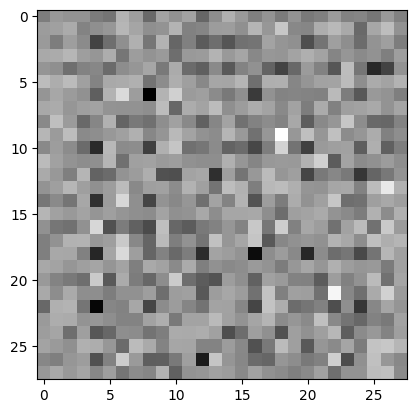

In [6]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

El discriminador toma una imagen de 28x28 píxeles como entrada y la procesa a través de capas convolucionales. Utiliza capas de `Dropout` para prevenir el sobreajuste y reduce la dimensionalidad de la imagen con una capa `Flatten`. Finalmente, una capa densa con una única salida determina si la imagen es real o generada por el modelo, proporcionando una probabilidad.

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten()) 
    model.add(layers.Dense(1))

    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00453138]], shape=(1, 1), dtype=float32)


C:\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1. `real_loss`: Calcula la pérdida del discriminador al clasificar imágenes reales. Compara las salidas del discriminador (`real_output`) con un conjunto de etiquetas de unos (porque las imágenes reales deberían clasificarse como "reales"). Se utiliza la función de pérdida de entropía cruzada (`cross_entropy`) para esta comparación.

2. `fake_loss`: Calcula la pérdida del discriminador al clasificar imágenes generadas (falsas). Compara las salidas del discriminador (`fake_output`) con etiquetas de ceros (porque las imágenes generadas deberían clasificarse como "falsas").

3. `total_loss`: Suma las pérdidas de las imágenes reales y generadas para obtener la pérdida total del discriminador.

El objetivo es minimizar esta pérdida, de modo que el discriminador mejore en clasificar imágenes reales como reales y falsas como falsas.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Esta función define la pérdida del generador. El objetivo del generador es crear imágenes falsas que engañen al discriminador haciéndole creer que son reales.

1. `fake_output`: Es la salida del discriminador al clasificar las imágenes generadas por el generador.

2. `cross_entropy(tf.ones_like(fake_output), fake_output)`: Calcula la pérdida del generador comparando las salidas del discriminador (`fake_output`) con un conjunto de etiquetas de unos (porque el generador quiere que el discriminador clasifique las imágenes falsas como "reales"). Se utiliza la función de entropía cruzada para medir qué tan bien está logrando esto.

El generador trata de minimizar esta pérdida, de modo que el discriminador no pueda diferenciar entre las imágenes reales y las generadas.

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

La anotación `@tf.function` optimiza la función compilándola para que sea más rápida.

1. **Generación de ruido**: Se crea un vector de ruido aleatorio con dimensiones `[BATCH_SIZE, noise_dim]` para alimentar al generador.

2. **GradientTape**: `
   - Se utilizan dos tf.GradientTape`, uno para el generador (`gen_tape`) y otro para el discriminador (`disc_tape`). Esto permite calcular los gradientes para ambos modelos.
   
3. **Generación de imágenes**: El generador usa el ruido para generar imágenes falsas (`generated_images`).

4. **Evaluación del discriminador**:
   - `real_output`: El discriminador procesa las imágenes reales y devuelve una clasificación.
   - `fake_output`: El discriminador evalúa las imágenes generadas y también devuelve una clasificación.

5. **Cálculo de pérdidas**:
   - `gen_loss`: Pérdida del generador, basada en qué tan bien las imágenes generadas engañan al discriminador.
   - `disc_loss`: Pérdida del discriminador, basada en su capacidad para diferenciar entre imágenes reales y generadas.

6. **Cálculo de gradientes**:
   - Se calculan los gradientes de la pérdida con respecto a los pesos entrenables del generador y el discriminador.

7. **Actualización de los modelos**:
   - `generator_optimizer.apply_gradients`: Aplica los gradientes calculados para actualizar los pesos del generador.
   - `discriminator_optimizer.apply_gradients`: Hace lo mismo para el discriminador.

En resumen, este bloque realiza un paso completo de entrenamiento, ajustando tanto el generador como el discriminador para que ambos mejoren en sus respectivos objetivos (engañar o no ser engañado).

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
g_losses = []
d_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def plot_losses(epoch):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.title(f'Losses after {epoch} epochs')
    plt.legend()
    plt.show()



In [14]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Loss Over Time')
    plt.show()


1. **Inicio del bucle de épocas**:
   - El entrenamiento se repite por la cantidad de épocas definida en el argumento `epochs`.
   - Al inicio de cada época, se registra el tiempo con `start = time.time()` para medir cuánto tarda cada una.

2. **Entrenamiento por lotes**:
   - Dentro de cada época, se itera sobre cada lote de imágenes del conjunto de datos (`dataset`), llamando a la función `train_step(image_batch)` para entrenar el generador y discriminador en ese lote.

3. **Generación de imágenes**:
   - Se genera y guarda una imagen utilizando la función `generate_and_save_images(generator, epoch + 1, seed)`, donde el generador crea nuevas imágenes a partir de una semilla (`seed`), permitiendo un seguimiento visual del progreso de la GAN.

4. **Medición del tiempo**:
   - Se calcula y muestra el tiempo que tomó completar cada época con `print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))`.

5. **Generación final**:
   - Después de la última época, se genera una imagen final con el mismo método de visualización.

En resumen, esta función coordina el entrenamiento de la GAN durante múltiples épocas, mide el tiempo por cada una y genera imágenes en cada iteración para ver cómo mejora la calidad de las imágenes generadas.

In [16]:
def train(dataset, epochs):
  generator_losses = []
  discriminator_losses = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      generator_losses.append(gen_loss)
      discriminator_losses.append(disc_loss)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Create the graph with both lines
    plt.plot(generator_losses, label='Generator Losses')
    plt.plot(discriminator_losses, label='Discriminator Losses')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Loss')
    plt.title('Generator vs Discriminator Loss')

    # Add a legend
    plt.legend()

    # Display the graph
    plt.show()

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


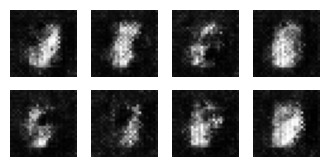

Time for epoch 1 is 46.088550090789795 sec


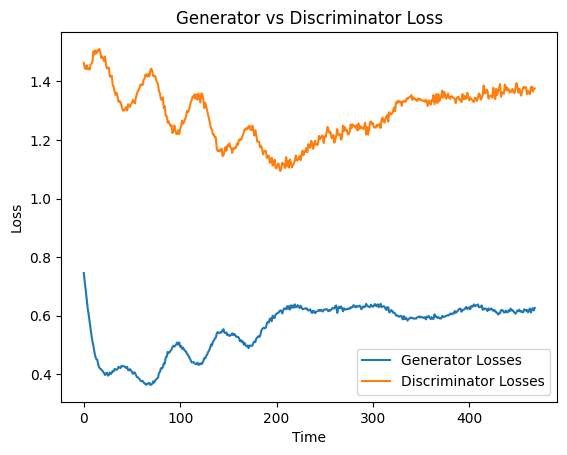

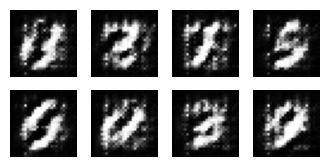

Time for epoch 2 is 41.86744785308838 sec


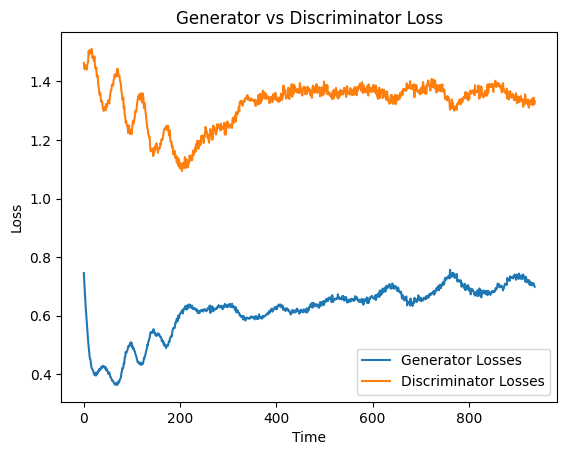

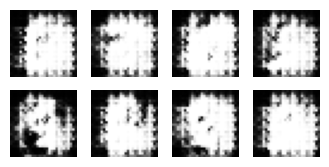

Time for epoch 3 is 41.12817931175232 sec


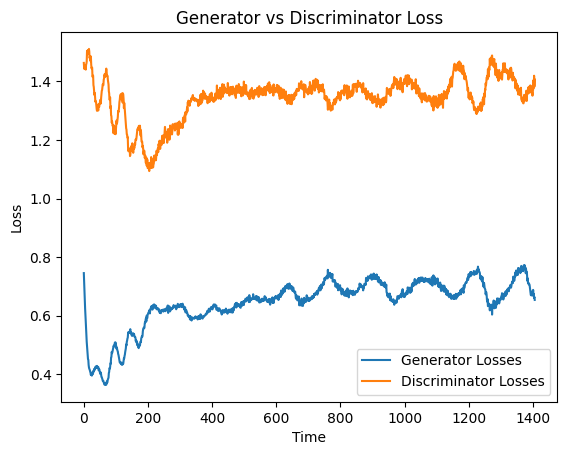

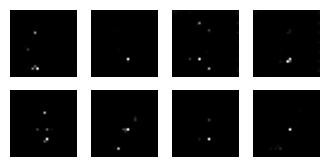

Time for epoch 4 is 42.398661375045776 sec


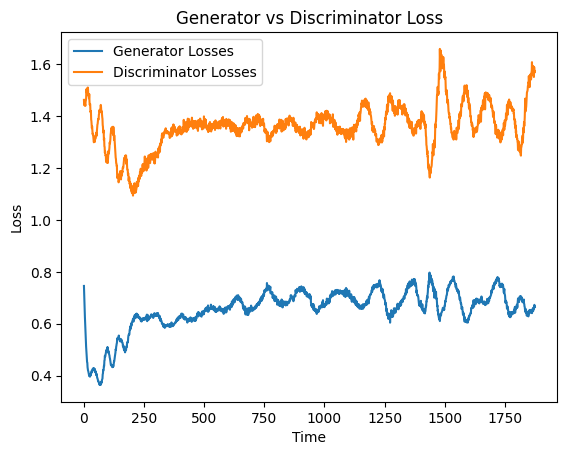

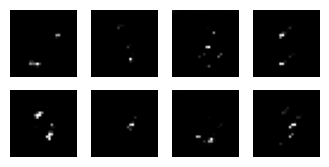

Time for epoch 5 is 42.86038565635681 sec


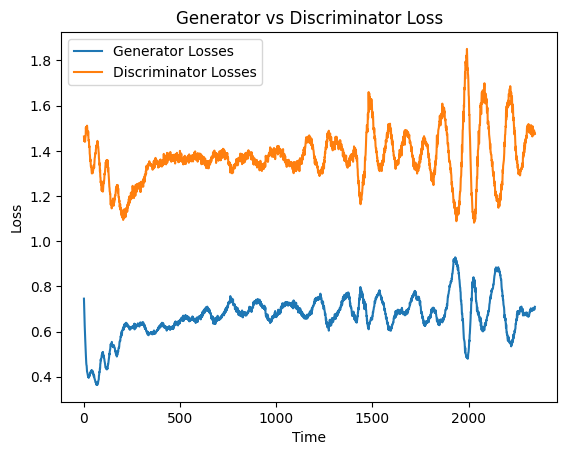

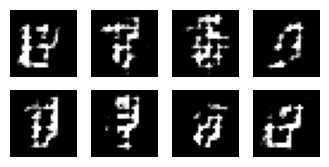

Time for epoch 6 is 45.8011417388916 sec


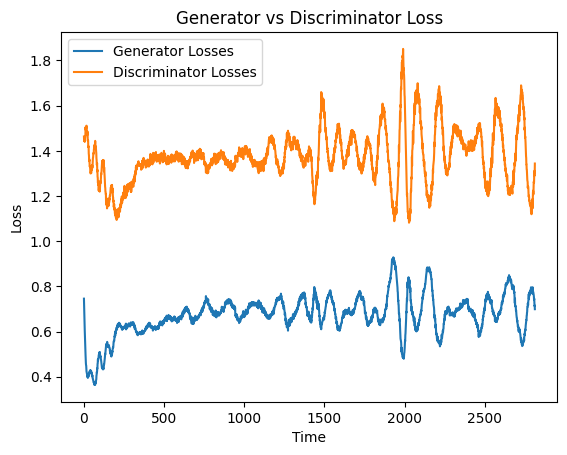

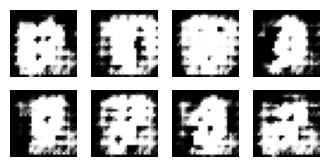

Time for epoch 7 is 49.22686266899109 sec


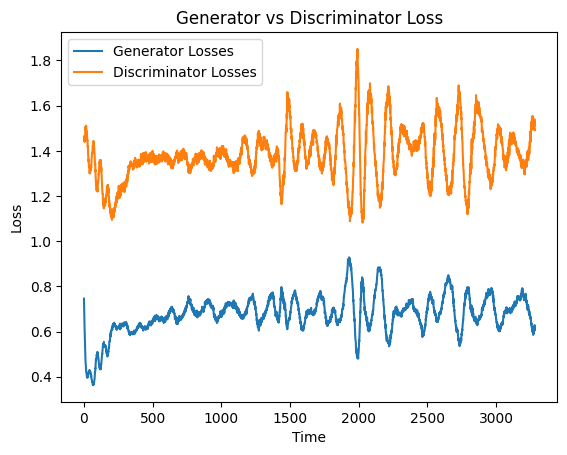

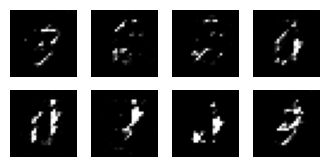

Time for epoch 8 is 43.78386950492859 sec


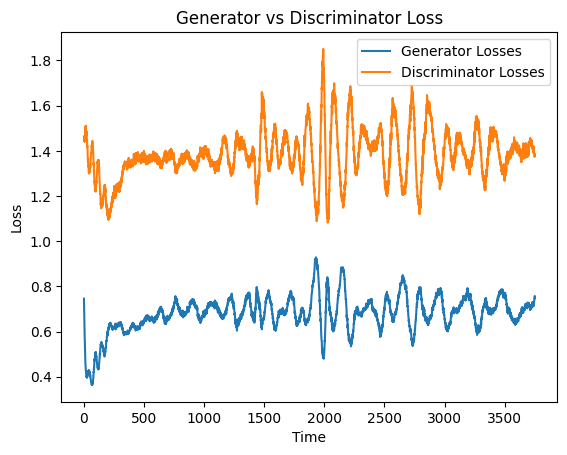

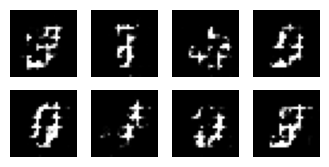

Time for epoch 9 is 44.173168897628784 sec


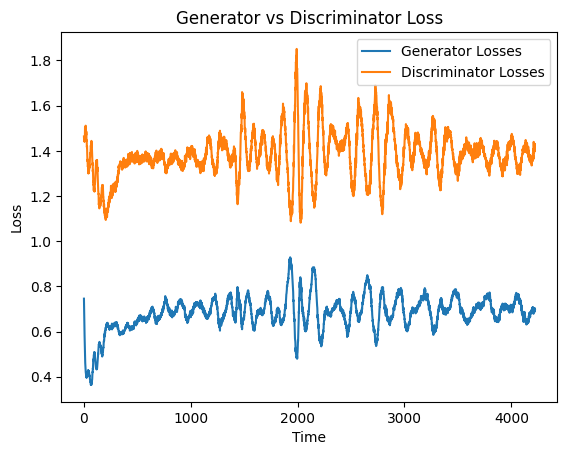

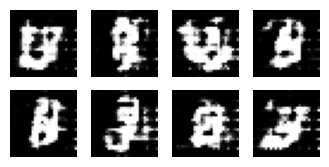

Time for epoch 10 is 44.65642523765564 sec


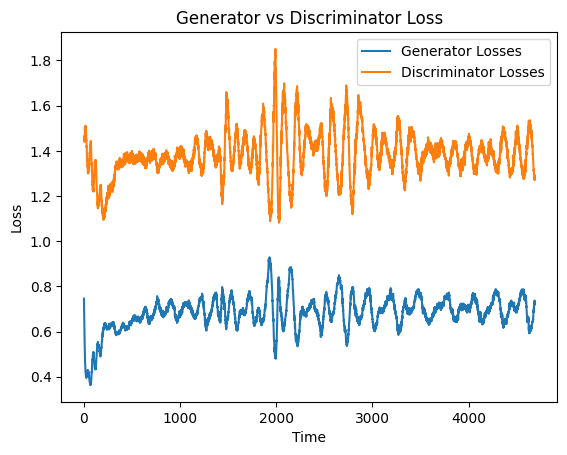

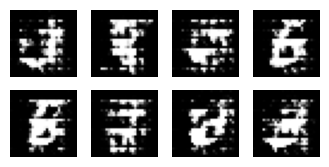

Time for epoch 11 is 48.85533308982849 sec


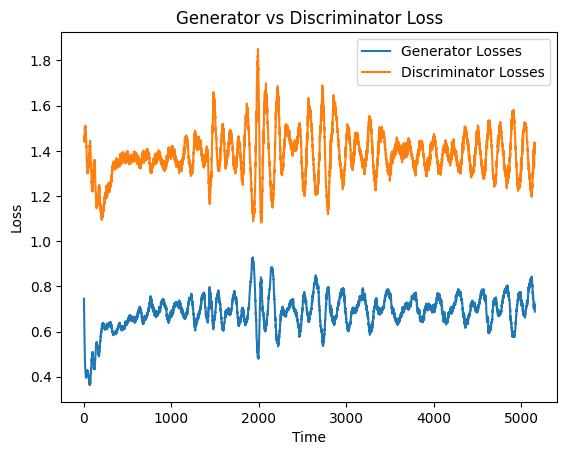

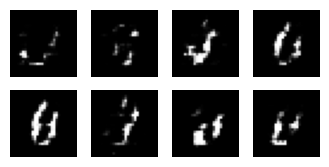

Time for epoch 12 is 47.592514753341675 sec


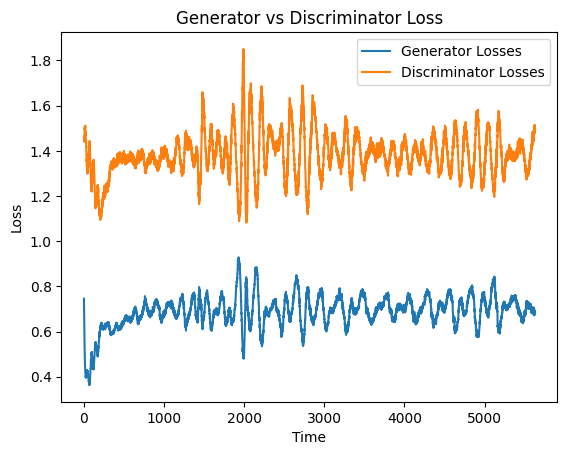

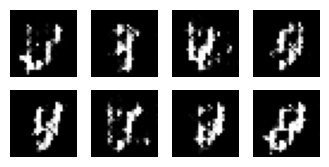

Time for epoch 13 is 46.13072323799133 sec


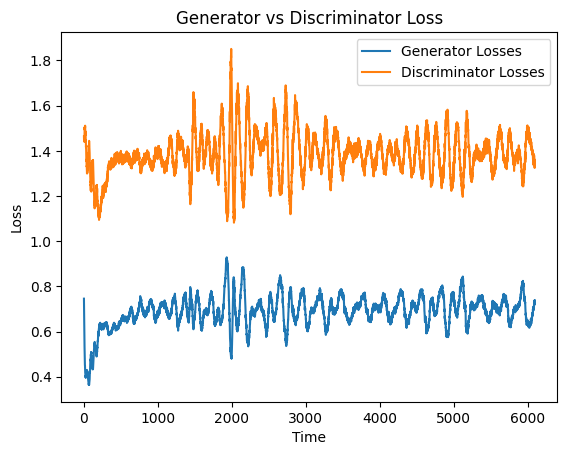

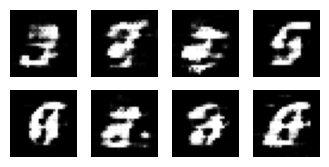

Time for epoch 14 is 46.12250852584839 sec


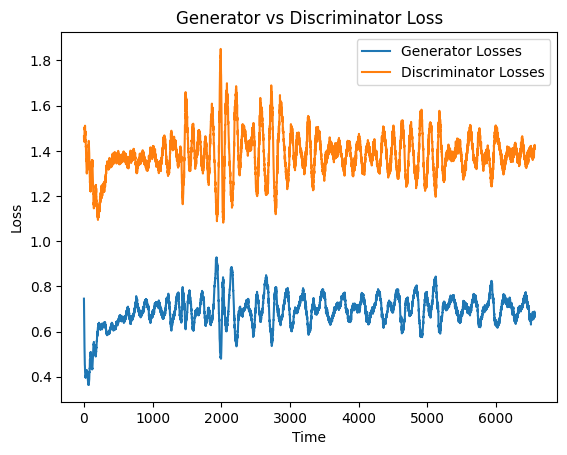

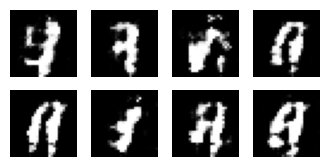

Time for epoch 15 is 49.43243169784546 sec


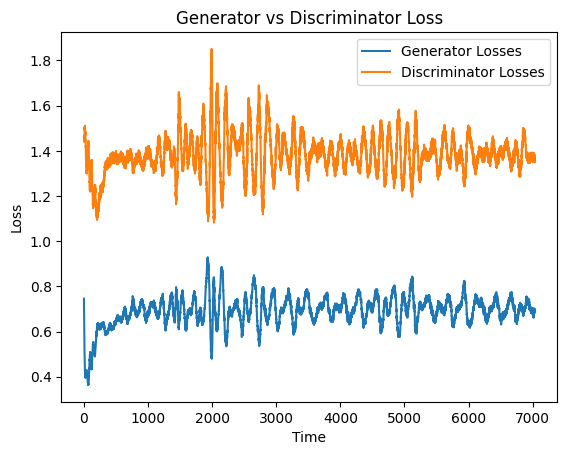

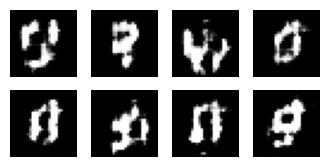

Time for epoch 16 is 48.545790910720825 sec


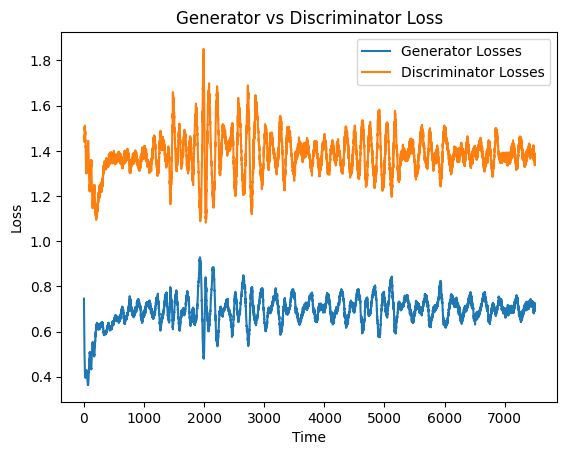

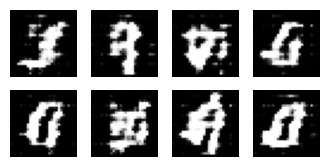

Time for epoch 17 is 45.351638078689575 sec


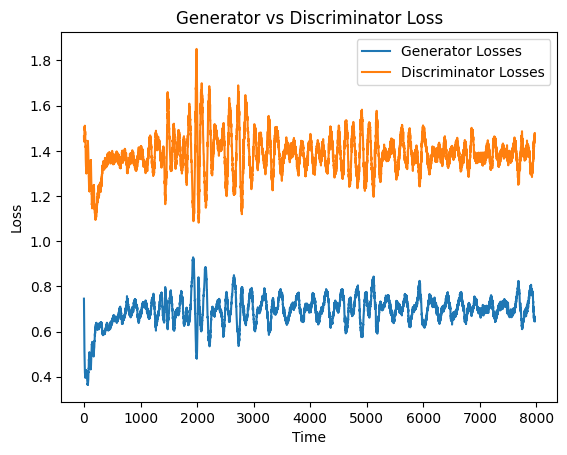

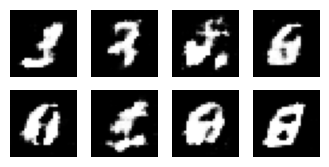

Time for epoch 18 is 46.25021028518677 sec


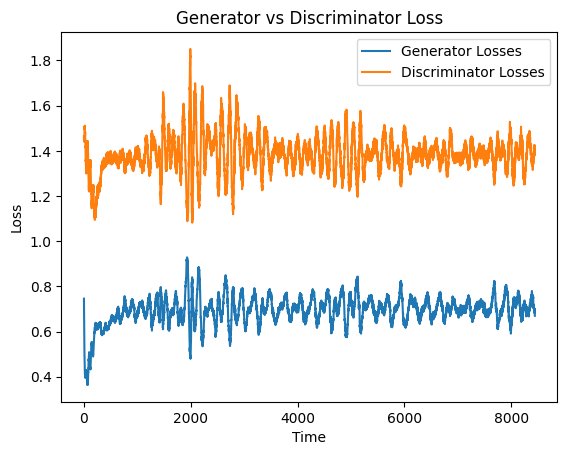

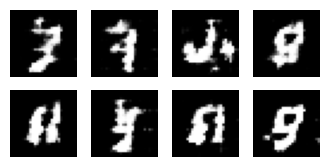

Time for epoch 19 is 46.132487535476685 sec


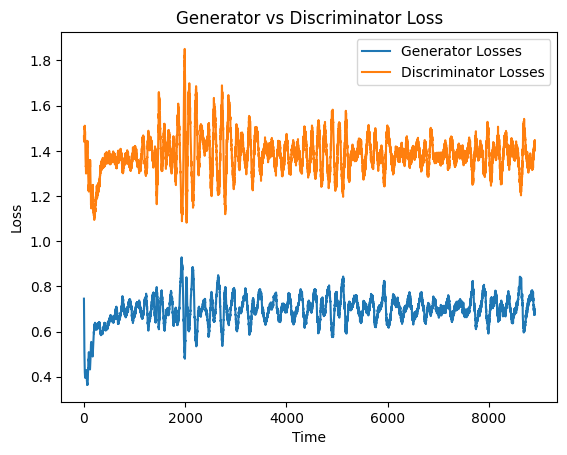

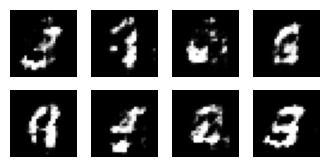

Time for epoch 20 is 46.36671328544617 sec


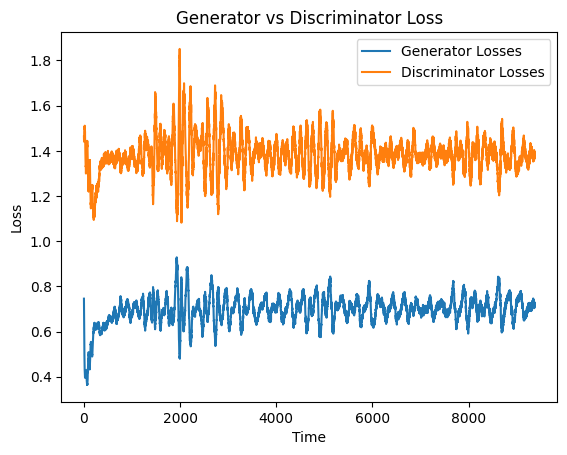

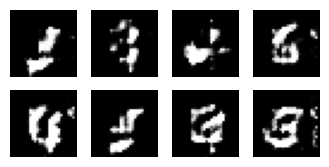

Time for epoch 21 is 43.84416484832764 sec


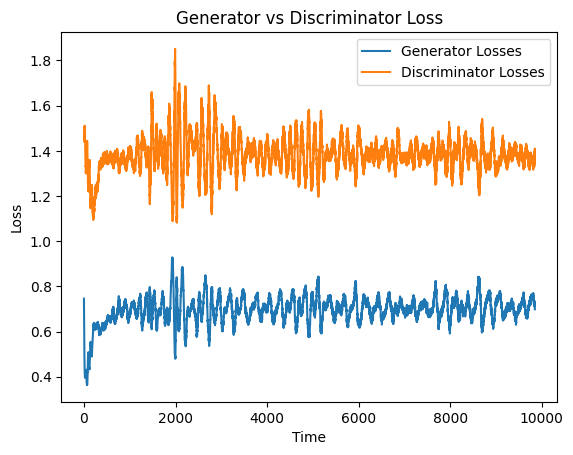

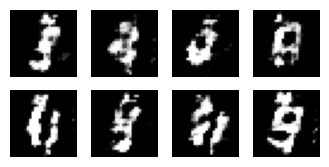

Time for epoch 22 is 47.06602430343628 sec


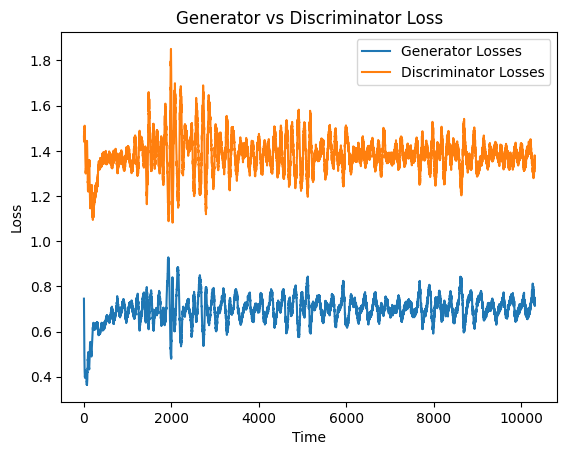

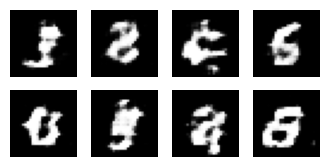

Time for epoch 23 is 44.941746950149536 sec


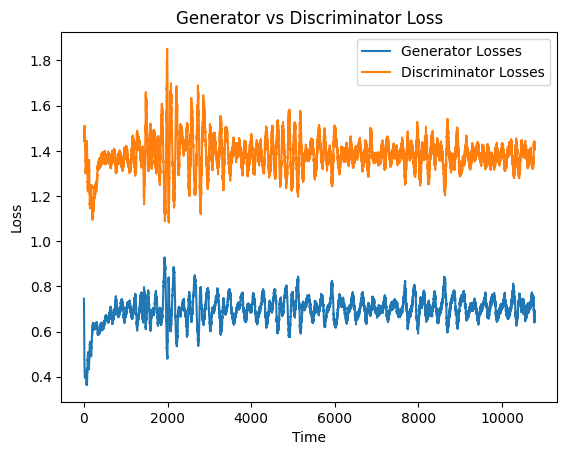

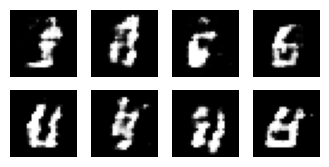

Time for epoch 24 is 44.077577352523804 sec


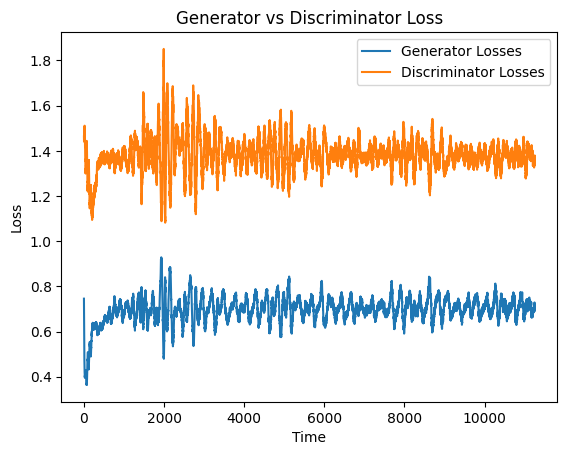

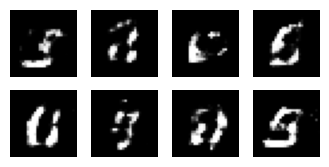

Time for epoch 25 is 44.43437051773071 sec


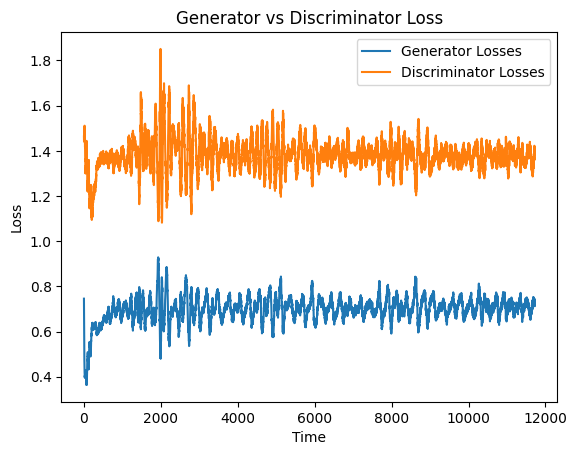

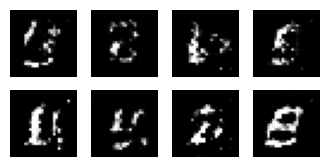

Time for epoch 26 is 44.252190828323364 sec


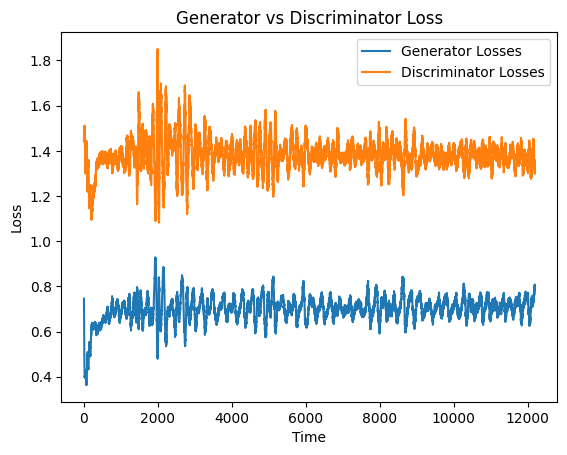

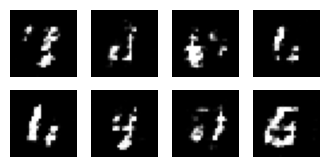

Time for epoch 27 is 50.13765811920166 sec


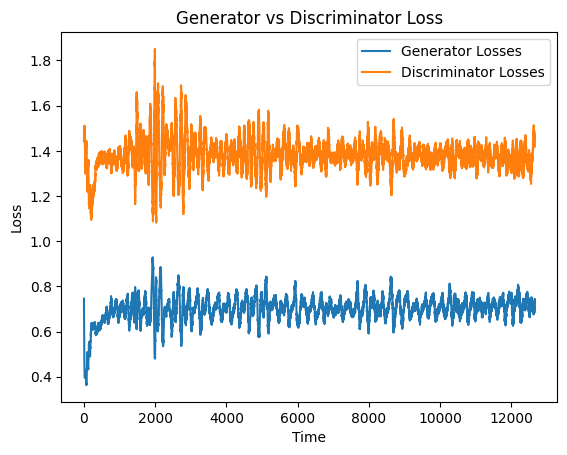

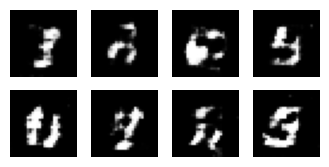

Time for epoch 28 is 49.618921756744385 sec


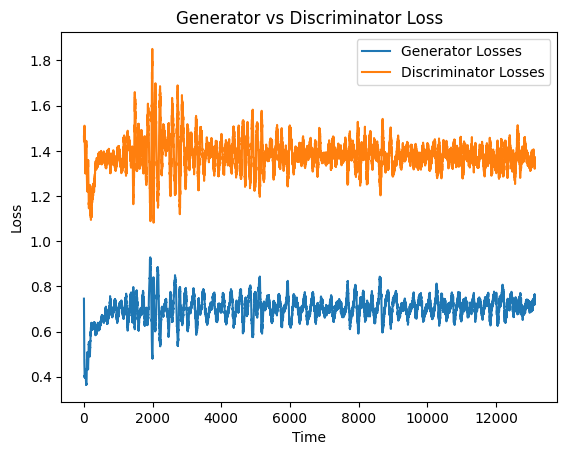

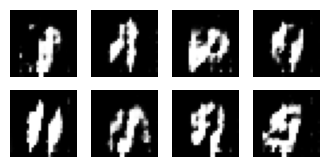

Time for epoch 29 is 49.16055655479431 sec


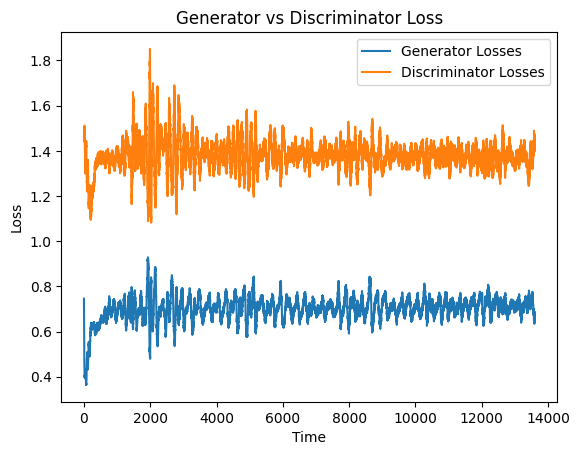

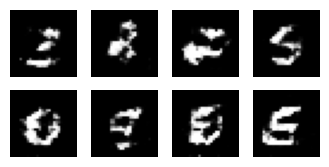

Time for epoch 30 is 48.773210287094116 sec


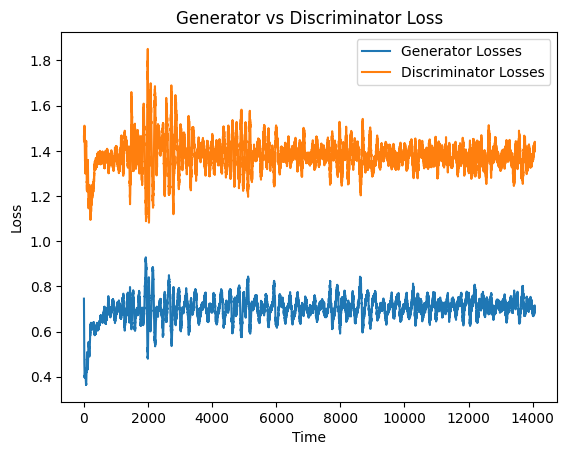

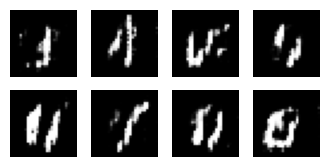

Time for epoch 31 is 49.117554903030396 sec


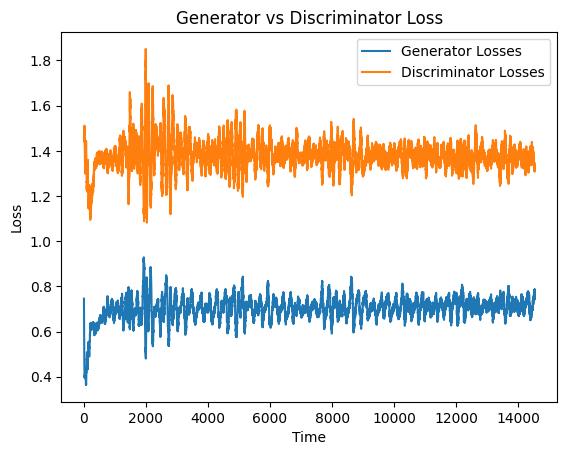

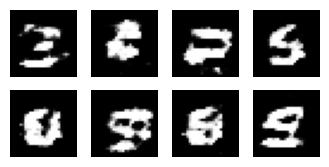

Time for epoch 32 is 47.719192028045654 sec


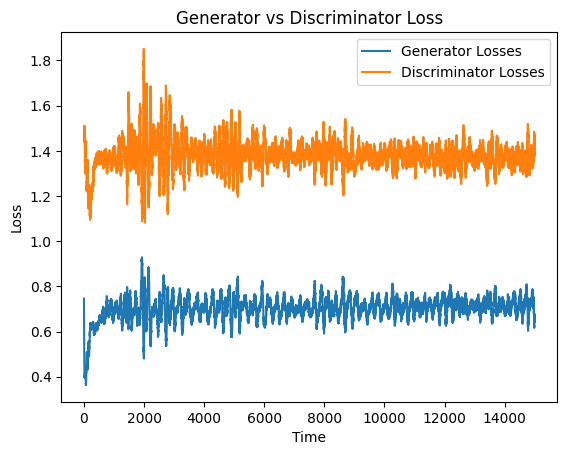

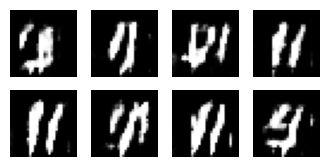

Time for epoch 33 is 46.78104019165039 sec


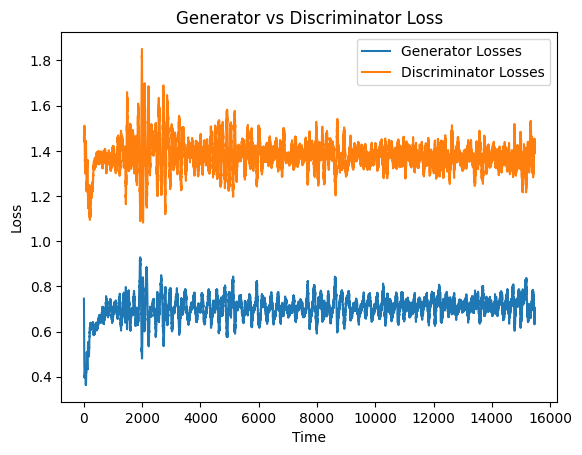

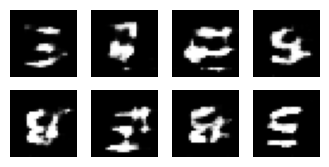

Time for epoch 34 is 46.97817301750183 sec


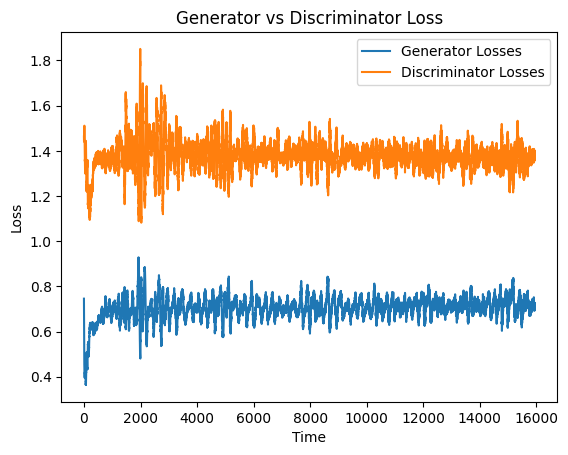

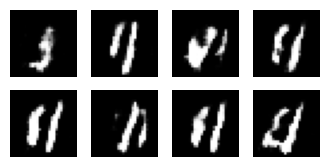

Time for epoch 35 is 46.81310534477234 sec


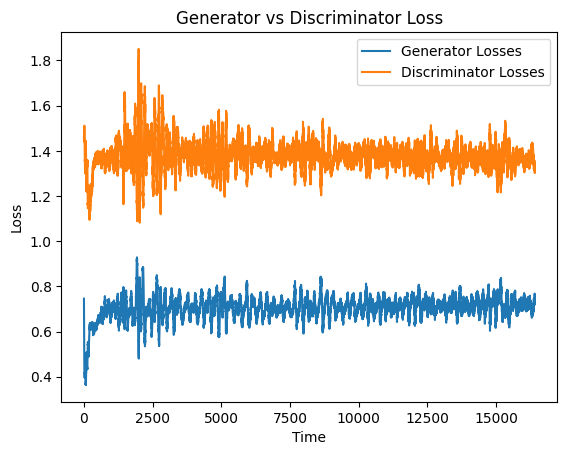

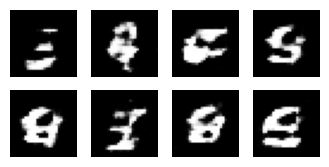

Time for epoch 36 is 48.00606870651245 sec


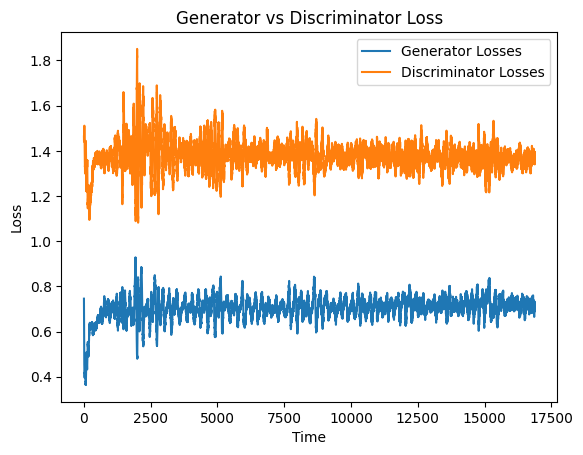

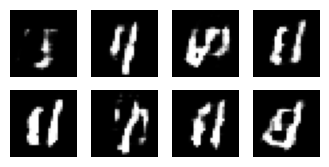

Time for epoch 37 is 47.41584658622742 sec


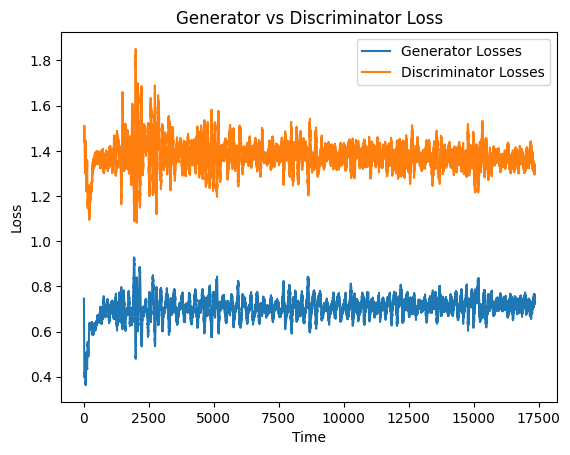

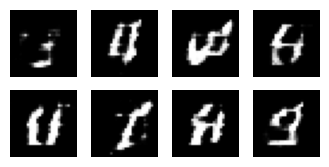

Time for epoch 38 is 46.65356731414795 sec


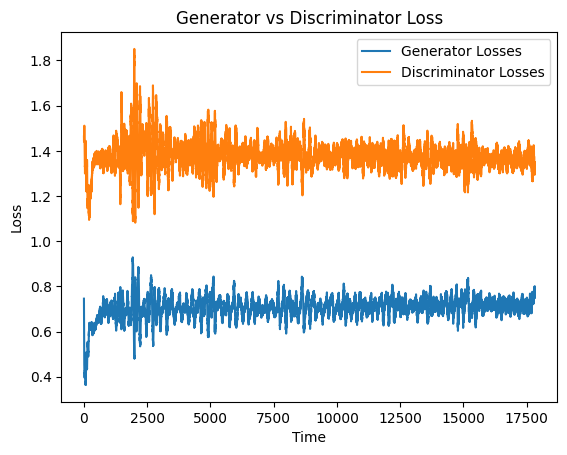

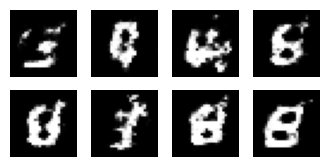

Time for epoch 39 is 46.79992985725403 sec


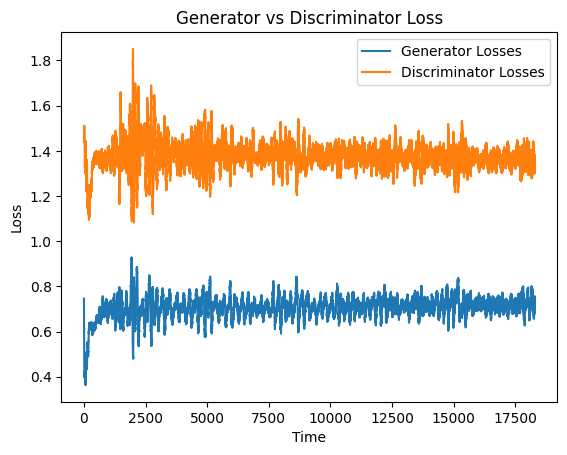

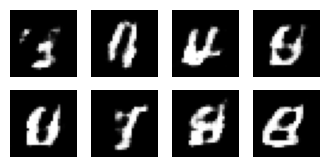

Time for epoch 40 is 43.384870290756226 sec


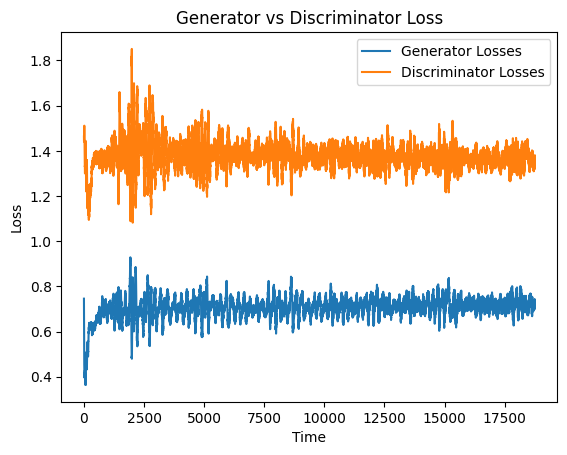

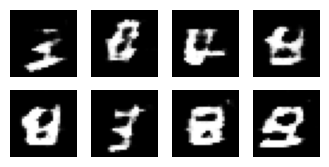

Time for epoch 41 is 41.43331980705261 sec


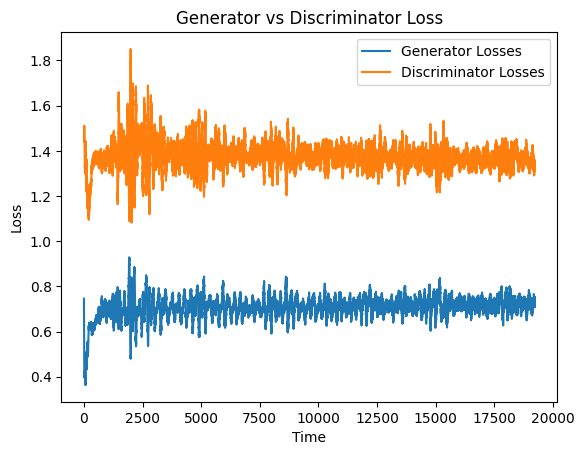

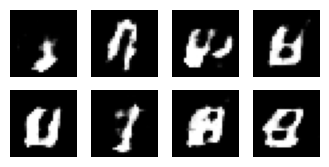

Time for epoch 42 is 40.69390082359314 sec


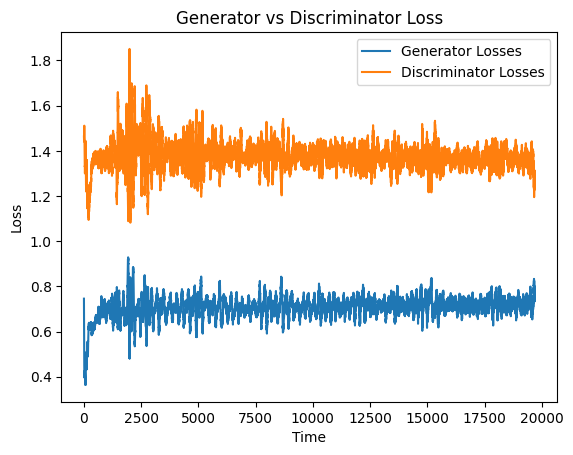

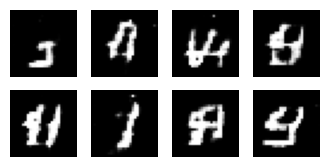

Time for epoch 43 is 40.14366102218628 sec


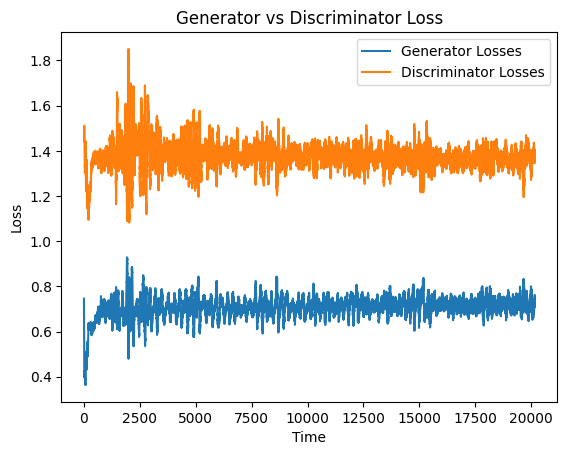

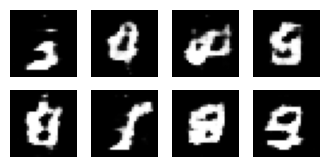

Time for epoch 44 is 41.12337636947632 sec


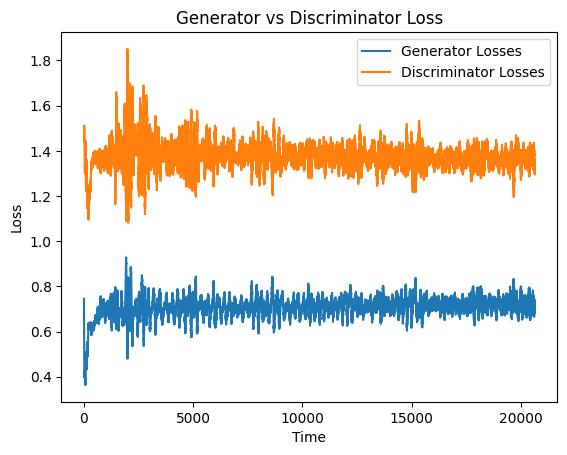

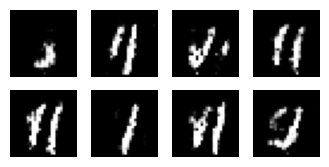

Time for epoch 45 is 43.3035786151886 sec


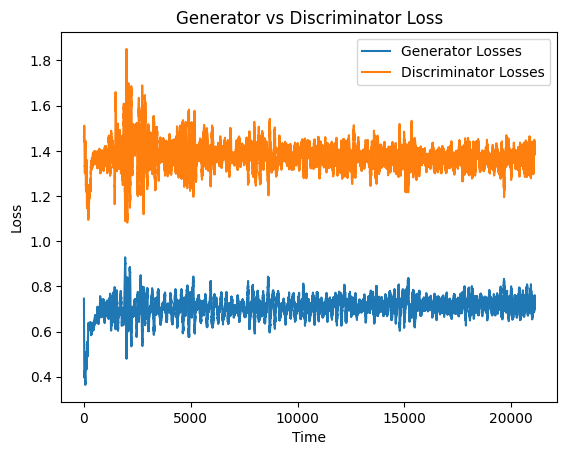

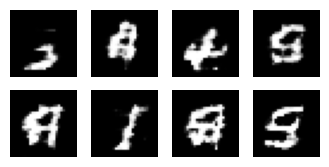

Time for epoch 46 is 40.5347535610199 sec


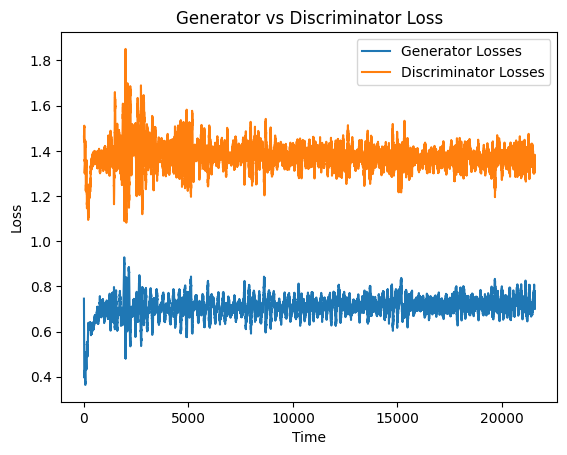

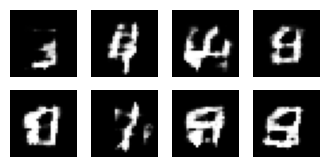

Time for epoch 47 is 40.90247297286987 sec


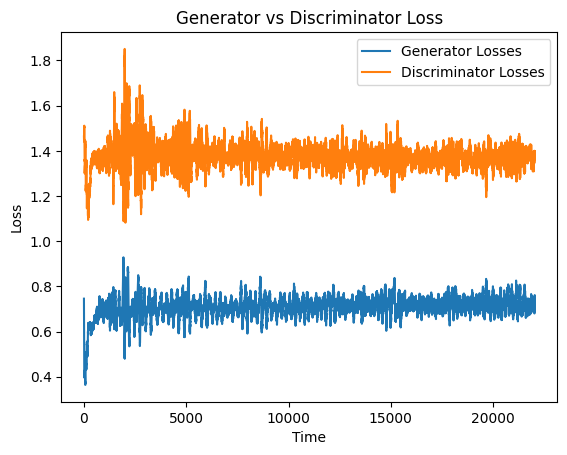

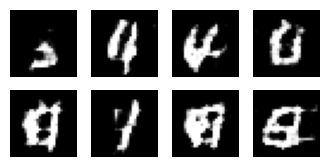

Time for epoch 48 is 41.67571449279785 sec


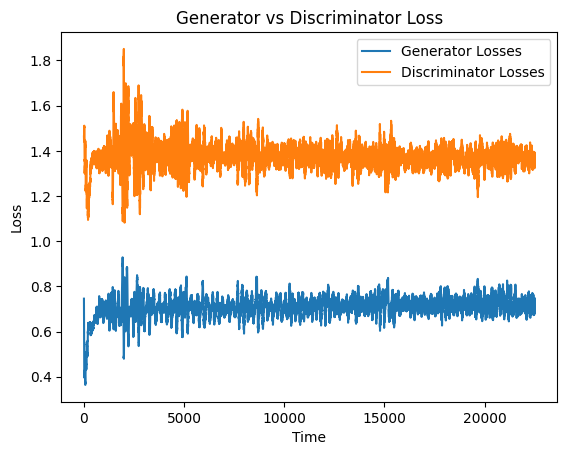

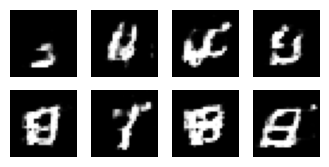

Time for epoch 49 is 45.22110176086426 sec


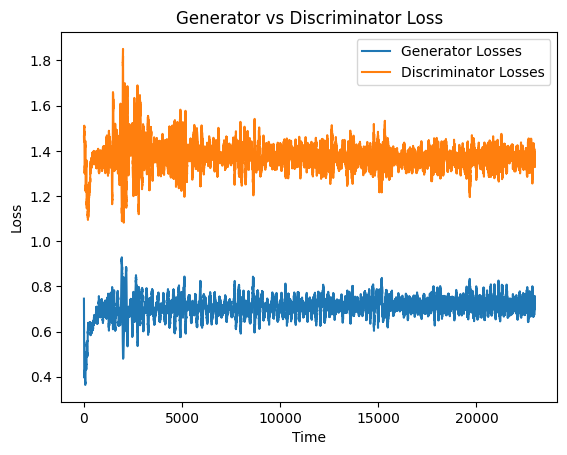

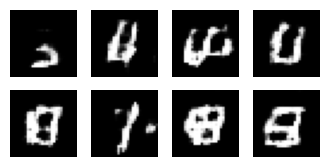

Time for epoch 50 is 44.95635271072388 sec


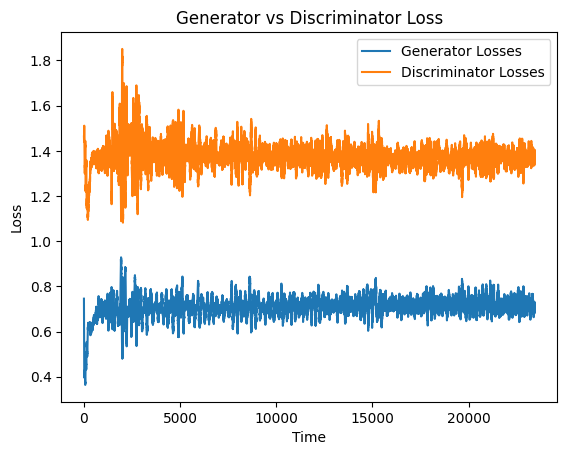

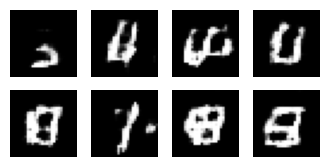

In [17]:
train(train_dataset, EPOCHS)

In [18]:
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1

        # Almacenar la pérdida promedio por cada época
        gen_losses.append(epoch_gen_loss / num_batches)
        disc_losses.append(epoch_disc_loss / num_batches)

        # Produce imágenes cada 10 épocas
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('Generator loss: {:.4f}, Discriminator loss: {:.4f}'.format(
            gen_losses[-1], disc_losses[-1]))

    # Generar después de la última época
    generate_and_save_images(generator, epochs, seed)

    # Graficar las pérdidas después de todo el entrenamiento
    plot_losses(gen_losses, disc_losses)


Time for epoch 1 is 44.34486508369446 sec
Generator loss: 0.7173, Discriminator loss: 1.3693
Time for epoch 2 is 40.87682127952576 sec
Generator loss: 0.7203, Discriminator loss: 1.3698
Time for epoch 3 is 43.75622797012329 sec
Generator loss: 0.7199, Discriminator loss: 1.3751
Time for epoch 4 is 48.3640832901001 sec
Generator loss: 0.7182, Discriminator loss: 1.3683
Time for epoch 5 is 50.29756164550781 sec
Generator loss: 0.7206, Discriminator loss: 1.3655
Time for epoch 6 is 44.036779165267944 sec
Generator loss: 0.7169, Discriminator loss: 1.3760
Time for epoch 7 is 41.224721908569336 sec
Generator loss: 0.7167, Discriminator loss: 1.3709
Time for epoch 8 is 48.18806052207947 sec
Generator loss: 0.7199, Discriminator loss: 1.3706
Time for epoch 9 is 46.41534066200256 sec
Generator loss: 0.7171, Discriminator loss: 1.3709


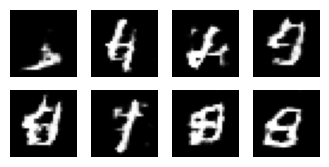

Time for epoch 10 is 48.729910135269165 sec
Generator loss: 0.7195, Discriminator loss: 1.3647
Time for epoch 11 is 47.987628698349 sec
Generator loss: 0.7126, Discriminator loss: 1.3735
Time for epoch 12 is 48.45175051689148 sec
Generator loss: 0.7153, Discriminator loss: 1.3692
Time for epoch 13 is 45.4212007522583 sec
Generator loss: 0.7147, Discriminator loss: 1.3720
Time for epoch 14 is 39.36586856842041 sec
Generator loss: 0.7265, Discriminator loss: 1.3684
Time for epoch 15 is 39.24213981628418 sec
Generator loss: 0.7180, Discriminator loss: 1.3685
Time for epoch 16 is 39.61160135269165 sec
Generator loss: 0.7228, Discriminator loss: 1.3655
Time for epoch 17 is 40.82489204406738 sec
Generator loss: 0.7132, Discriminator loss: 1.3743
Time for epoch 18 is 39.55391883850098 sec
Generator loss: 0.7138, Discriminator loss: 1.3715
Time for epoch 19 is 39.3071231842041 sec
Generator loss: 0.7171, Discriminator loss: 1.3703


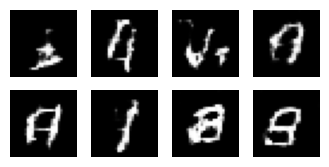

Time for epoch 20 is 39.42486548423767 sec
Generator loss: 0.7220, Discriminator loss: 1.3691
Time for epoch 21 is 39.433563470840454 sec
Generator loss: 0.7144, Discriminator loss: 1.3729
Time for epoch 22 is 39.54426884651184 sec
Generator loss: 0.7212, Discriminator loss: 1.3690
Time for epoch 23 is 39.31020402908325 sec
Generator loss: 0.7152, Discriminator loss: 1.3710
Time for epoch 24 is 39.50459814071655 sec
Generator loss: 0.7193, Discriminator loss: 1.3728
Time for epoch 25 is 39.226643085479736 sec
Generator loss: 0.7214, Discriminator loss: 1.3635
Time for epoch 26 is 39.306570291519165 sec
Generator loss: 0.7253, Discriminator loss: 1.3706
Time for epoch 27 is 39.41720628738403 sec
Generator loss: 0.7149, Discriminator loss: 1.3716
Time for epoch 28 is 39.282397508621216 sec
Generator loss: 0.7237, Discriminator loss: 1.3648
Time for epoch 29 is 39.469457387924194 sec
Generator loss: 0.7163, Discriminator loss: 1.3684


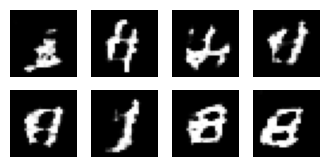

Time for epoch 30 is 39.638115644454956 sec
Generator loss: 0.7262, Discriminator loss: 1.3671
Time for epoch 31 is 39.34709191322327 sec
Generator loss: 0.7169, Discriminator loss: 1.3680
Time for epoch 32 is 40.64573097229004 sec
Generator loss: 0.7242, Discriminator loss: 1.3691
Time for epoch 33 is 40.22369027137756 sec
Generator loss: 0.7149, Discriminator loss: 1.3695
Time for epoch 34 is 39.02967381477356 sec
Generator loss: 0.7253, Discriminator loss: 1.3668
Time for epoch 35 is 39.16636681556702 sec
Generator loss: 0.7167, Discriminator loss: 1.3708
Time for epoch 36 is 39.06665110588074 sec
Generator loss: 0.7188, Discriminator loss: 1.3672
Time for epoch 37 is 39.31717586517334 sec
Generator loss: 0.7161, Discriminator loss: 1.3719
Time for epoch 38 is 39.11588478088379 sec
Generator loss: 0.7220, Discriminator loss: 1.3674
Time for epoch 39 is 38.961896657943726 sec
Generator loss: 0.7227, Discriminator loss: 1.3683


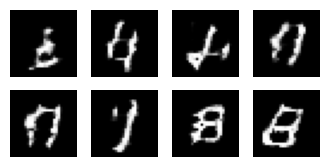

Time for epoch 40 is 39.17428421974182 sec
Generator loss: 0.7253, Discriminator loss: 1.3715
Time for epoch 41 is 39.18699884414673 sec
Generator loss: 0.7204, Discriminator loss: 1.3691
Time for epoch 42 is 39.11506748199463 sec
Generator loss: 0.7172, Discriminator loss: 1.3702
Time for epoch 43 is 40.392220973968506 sec
Generator loss: 0.7178, Discriminator loss: 1.3690
Time for epoch 44 is 42.87535095214844 sec
Generator loss: 0.7161, Discriminator loss: 1.3721
Time for epoch 45 is 45.63560342788696 sec
Generator loss: 0.7224, Discriminator loss: 1.3681
Time for epoch 46 is 41.91673707962036 sec
Generator loss: 0.7205, Discriminator loss: 1.3649
Time for epoch 47 is 39.52514123916626 sec
Generator loss: 0.7191, Discriminator loss: 1.3702
Time for epoch 48 is 39.36967396736145 sec
Generator loss: 0.7195, Discriminator loss: 1.3690
Time for epoch 49 is 39.61858415603638 sec
Generator loss: 0.7192, Discriminator loss: 1.3690


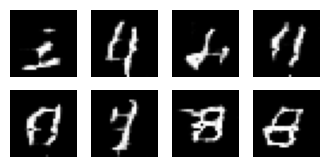

Time for epoch 50 is 41.25324296951294 sec
Generator loss: 0.7222, Discriminator loss: 1.3724


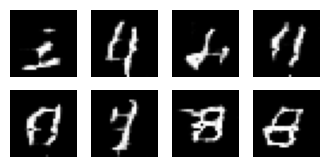

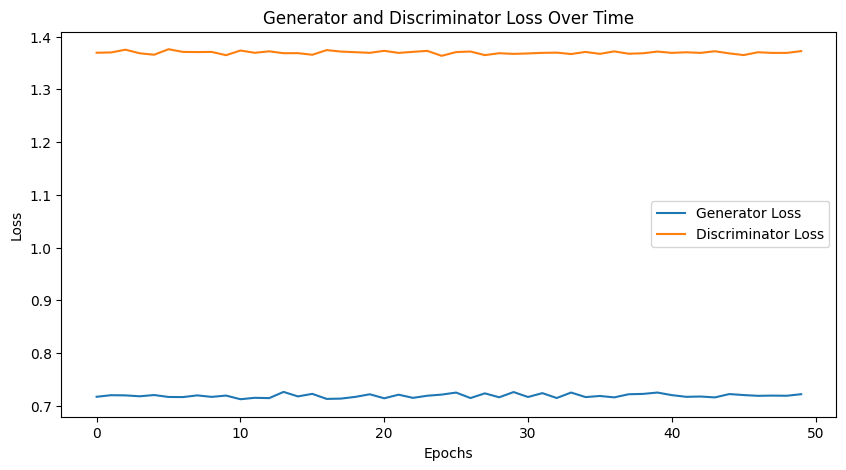

In [19]:
train(train_dataset, EPOCHS)